In [1]:
import cv2
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

np.set_printoptions(precision=4)

In [2]:
import json

base_path = "C:/Users/leeju/OneDrive/바탕 화면/labmeeting_IRV/000071"
scene_number = 71

scene_file= os.path.join(base_path, f'{scene_number:06d}', "C:/Users/leeju/OneDrive/바탕 화면/labmeeting_IRV/000071/000071/scene_20fe05b2418deafbaaabfdc005b9828fa2e0a455.json")
with open(scene_file, 'r') as f:
    scene = json.load(f)

In [3]:
calib_file = os.path.join(base_path, f'{scene_number:06d}', 'calibration', '3d9f21a7abaca3ea61d07266dce09cfb995b79ec.json')
with open(calib_file, 'r') as f:
    calib = json.load(f)

In [4]:
#frame이 의미하는 바가 뭐지..?
frame = 10

sensor_idx = 1      # camera_01
index = (frame - 1) * (6 + 1) + sensor_idx    # 10th frame, total 6 cameras + 1 LiDAR, + 1 is for offset of camera_01

datum = scene['data'][index]['datum']
print(datum)

{'image': {'annotations': {}, 'channels': 3, 'filename': 'rgb/CAMERA_01/1568648964595300.png', 'height': 1216, 'metadata': {}, 'pose': {'rotation': {'qw': 0.48471607341096606, 'qx': -0.49109006200972805, 'qy': -0.518400222852208, 'qz': 0.5051159155274331}, 'translation': {'x': 1289.5001529722776, 'y': 3019.708767664828, 'z': 64.09066116811032}}, 'width': 1936}}


In [5]:
filename = os.path.join(base_path, f'{scene_number:06d}', 'rgb','CAMERA_01','1568648963695300.png')
print(filename)

C:/Users/leeju/OneDrive/바탕 화면/labmeeting_IRV/000071\000071\rgb\CAMERA_01\1568648963695300.png


In [6]:
stream = open(filename, "rb")
bytes = bytearray(stream.read())
numpyarray = np.asarray(bytes, dtype=np.uint8)
image_camera01 = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)
image_camera01 = image_camera01[:, :, (2, 1, 0)]  # BGR -> RGB
print(image_camera01.shape)

(1216, 1936, 3)


In [7]:
depth_camera01 = np.load(filename.replace('rgb', 'depth/lidar').replace('.png', '.npz'))['depth']
intrinsics_camera01 = calib['intrinsics'][sensor_idx]
#extrinsics_camera01 = calib['extrinsics'][sensor_idx]     # Sometimes, has error
pose_camera01 = datum['image']['pose']

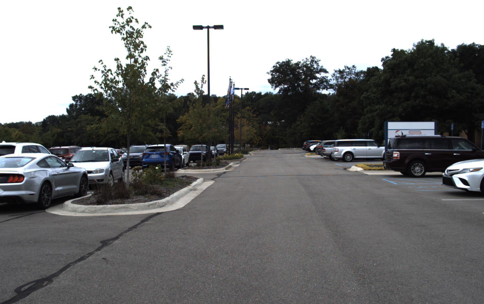

In [8]:
display(Image.fromarray(image_camera01).resize(size=(image_camera01.shape[1]//4, image_camera01.shape[0]//4)))

intrinsics {'cx': 936.0427302551566, 'cy': 600.170760834317, 'fx': 1064.653042104742, 'fy': 1063.2126057819257, 'skew': 0.0}
extrinsics {'rotation': {'qw': 0.22849002375349994, 'qx': -0.23379590948032292, 'qy': 0.6734285140316372, 'qz': -0.6630428479702764}, 'translation': {'x': 1.5458971683251548, 'y': -0.4044052438025574, 'z': 1.4904345068701055}}


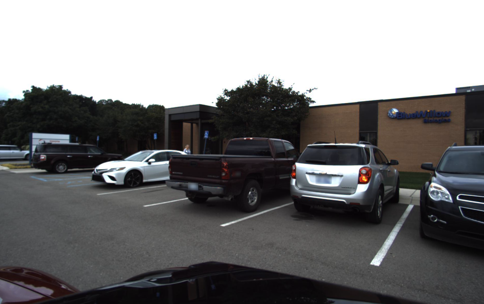

In [9]:
sensor_idx = 3      # camera_06
index = (frame - 1) * (6 + 1) + sensor_idx    # 10th frame, total 6 cameras + 1 LiDAR, + 1 is for offset of camera_01

datum = scene['data'][index]['datum']

filename = os.path.join(base_path, f'{scene_number:06d}', 'rgb', 'CAMERA_06', '1568648964595300.png')
stream = open(filename, "rb")
bytes = bytearray(stream.read())
numpyarray = np.asarray(bytes, dtype=np.uint8)
image_camera06 = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)
image_camera06 = image_camera06[:, :, (2, 1, 0)]  # BGR -> RGB

depth_camera06 = np.load(filename.replace('rgb', 'depth/lidar').replace('.png', '.npz'))['depth']

intrinsics_camera06 = calib['intrinsics'][sensor_idx]
extrinsics_camera06 = calib['extrinsics'][sensor_idx]     # Sometimes, has error
pose_camera06 = datum['image']['pose']
print("intrinsics",intrinsics_camera06)
print("extrinsics",extrinsics_camera06)
display(Image.fromarray(image_camera06).resize(size=(image_camera06.shape[1]//4, image_camera06.shape[0]//4)))

In [10]:
# For sanity check(코드가 잘 돌아가는 지 확인하는 체크)
sensor_idx = 0      # LiDAR
index = (frame - 1) * (6 + 1) + sensor_idx    # 10th frame, total 6 cameras + 1 LiDAR, + 1 is for offset of camera_01

datum = scene['data'][index]['datum']

pcd_file = os.path.join(base_path, f'{scene_number:06d}', 'point_cloud','LIDAR','1568648964612616.npz')
pcd_lidar = np.load(pcd_file)['data']

pose_lidar = datum['point_cloud']['pose']

In [11]:
# Code from https://github.com/facebookresearch/pytorch3d/blob/e245560abb8f019a24880faf7557ed3b2eec6cc0/pytorch3d/transforms/rotation_conversions.py#L41-L70

def quaternion_to_matrix(quaternions: np.ndarray) -> np.ndarray:
    """Convert rotations given as quaternions to rotation matrices.

    Parameters
    ----------
    quaternions: np.ndarray (4)
        quaternions with real part first
        
    Returns
    -------
    rotation_matrix: np.ndarray (3 x 3)
        converted rotation matrix
    """
    
    r, i, j, k = quaternions
    # pyre-fixme[58]: `/` is not supported for operand types `float` and `Tensor`.
    two_s = 2.0 / (quaternions ** 2).sum()

    o = np.array([
            1 - two_s * (j * j + k * k),
            two_s * (i * j - k * r),
            two_s * (i * k + j * r),
            two_s * (i * j + k * r),
            1 - two_s * (i * i + k * k),
            two_s * (j * k - i * r),
            two_s * (i * k - j * r),
            two_s * (j * k + i * r),
            1 - two_s * (i * i + j * j),
    ])
    rotation_matrix = o.reshape(3, 3)
    return rotation_matrix

In [12]:
def get_intrinsic_matrix(intrinsics):
    K = np.eye(3)
    K[0, 0] = intrinsics['fx']
    K[1, 1] = intrinsics['fy']
    K[0, 2] = intrinsics['cx']
    K[1, 2] = intrinsics['cy']
    return K

def get_pose_matrix(pose):
    quaternion = np.array([
        pose['rotation']['qw'],
        pose['rotation']['qx'],
        pose['rotation']['qy'],
        pose['rotation']['qz'],
    ])

    T_world_from_camera = np.eye(4)
    T_world_from_camera[:3, :3] = quaternion_to_matrix(quaternion)
    T_world_from_camera[ 0,  3] = pose['translation']['x']
    T_world_from_camera[ 1,  3] = pose['translation']['y']
    T_world_from_camera[ 2,  3] = pose['translation']['z']

    return T_world_from_camera

In [13]:
#Calibration된 matrix(intrinsic parameter 반영)
K_camera01 = get_intrinsic_matrix(intrinsics_camera01)
K_camera06 = get_intrinsic_matrix(intrinsics_camera06)

#월드 좌표계에서의 센서들 matrix(extrinsic parameter 반영)
T_world_from_camera01 = get_pose_matrix(pose_camera01)
T_world_from_camera06 = get_pose_matrix(pose_camera06)
T_world_from_lidar = get_pose_matrix(pose_lidar)

In [14]:
def get_pixel_grid(height, width, with_ones=True):
    """Create a pixel grid

    Parameters
    ----------
    height : int
        height of the grid
    width : int
        width of the grid        
    with_ones : Bool
        whether the ones are appended (homogeneous coordinate)

    Returns
    -------
    grid : np.ndarray (2 x H x W) or (3 x H x W)
        Output pixel grid
    """    
    xx, yy = np.meshgrid(
        np.linspace(0, width - 1, width),
        np.linspace(0, height - 1, height),        
        indexing='xy')    
    
    coords = [xx, yy]
    if with_ones:
        coords += [np.ones_like(xx)]
    grid = np.stack(coords, 0)
    return grid

In [15]:
def reconstruct_depth_map(depth, K, T_wc):
    """Reconstruct 3D points in world coordinate from depth map

    Parameters
    ----------
    depth : np.ndarray (H x W)
        input depth map
    K : np.ndarray (3 x 3)
        intrinsic matrix of the camera
    T_wc : np.ndarray (4 x 4)
        transformation to world coordinate from camera coordinate

    Returns
    -------
    points : np.ndarray (3 x H x W)
        output 3D points 
    """
    h, w = depth.shape
    K_inv = np.linalg.inv(K)  # (3 x 3)
    
    # Get a pixel grid (image coordinate)
    grid = get_pixel_grid(h, w, with_ones=True)
    grid = grid.reshape(3, -1)    # (3 x H x W) -> (3 x N)
        
    # Get 3D points in camera coordinate system
    #  - numpy broadcasting during element-wise multiplication
    #    : (1 x N) * (3 x N) -> (3 x N) (broadcasting) * (3 x N) -> (3 x N)
    pts3d_cam = depth.reshape(1, -1) * np.matmul(K_inv, grid)

    # Transform the coordinate, from camera to world
    pts3d_cam_homogeneous = np.concatenate([pts3d_cam, np.ones((1, h * w))], axis=0)
    pts3d_world = np.matmul(T_wc, pts3d_cam_homogeneous)
    pts3d_world = pts3d_world[:3]
    
    return pts3d_world.reshape(3, h, w)

In [16]:
# (Optional) resize rgb and depth for visualization
# be careful, if you resize rgb/depth, then intrinsic metrix(K) should be adjusted too.

def resize_npy_preserve(depth, shape, expand_dims=True):
    """
    Resizes depth map preserving all valid depth pixels
    Multiple downsampled points can be assigned to the same pixel.

    Parameters
    ----------
    depth : np.Array
        Depth map [h,w]
    shape : Tuple
        Output shape (H,W)

    Returns
    -------
    depth : np.Array
        Resized depth map [H,W,1]
    """

    # Store dimensions and reshapes to single column
    depth = np.squeeze(depth)
    h, w = depth.shape
    x = depth.reshape(-1)
    # Create coordinate grid
    uv = np.mgrid[:h, :w].transpose(1, 2, 0).reshape(-1, 2)
    # Filters valid points
    idx = x > 0
    crd, val = uv[idx], x[idx]
    # Downsamples coordinates
    crd[:, 0] = (crd[:, 0] * (shape[0] / h)).astype(np.int32)
    crd[:, 1] = (crd[:, 1] * (shape[1] / w)).astype(np.int32)
    # Filters points inside image
    idx = (crd[:, 0] < shape[0]) & (crd[:, 1] < shape[1])
    crd, val = crd[idx], val[idx]
    # Creates downsampled depth image and assigns points
    depth = np.zeros(shape)
    depth[crd[:, 0], crd[:, 1]] = val
    # Return resized depth map
    return np.expand_dims(depth, axis=2) if expand_dims else depth

In [17]:
# Without this resizing, LiDAR depth map is hard to see due to its sparsity.
src_shape = depth_camera01.shape
dst_shape = (384, 640)
print(src_shape)

(1216, 1936)


In [18]:
#LiDAR depth map을 이미지에 맞게 resizing
depth_camera01 = resize_npy_preserve(depth_camera01, dst_shape, expand_dims=False)
image_camera01 = cv2.resize(image_camera01, (dst_shape[1], dst_shape[0]))

depth_camera06 = resize_npy_preserve(depth_camera06, dst_shape, expand_dims=False)
image_camera06 = cv2.resize(image_camera06, (dst_shape[1], dst_shape[0]))

ratio_w = dst_shape[1] / src_shape[1] #1.0
ratio_h = dst_shape[0] / src_shape[0] #1.0

#rgb/depth map을 resizing했으므로, intrinsic matrix도 resizing해준다
#여기선 ratio_w, ratio_h가 값이 1이므로 결과적으론 둘이 동일
K_camera01[0, 0] *= ratio_w
K_camera01[1, 1] *= ratio_h
K_camera01[0, 2] *= ratio_w
K_camera01[1, 2] *= ratio_h

K_camera06[0, 0] *= ratio_w
K_camera06[1, 1] *= ratio_h
K_camera06[0, 2] *= ratio_w
K_camera06[1, 2] *= ratio_h


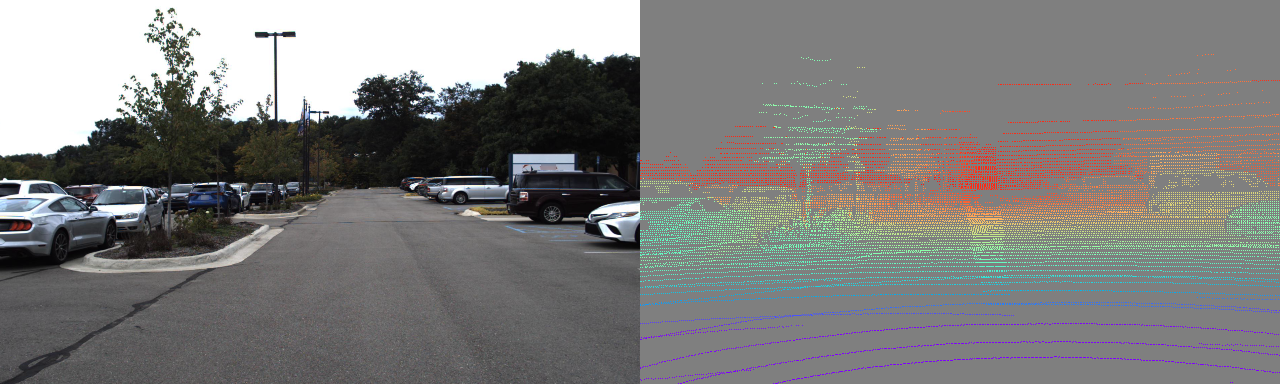

In [19]:
import matplotlib

def viz_depth(depth, background=(0.5, 0.5, 0.5)):
    # "depth == 0" means that there is no LiDAR point observed
    invalid = depth == 0

    inv_depth = 1. / depth.clip(1e-6, None)
    inv_depth[invalid] = 0.

    percentile = 95
    normalizer = np.percentile(inv_depth[inv_depth > 0], percentile)
    inv_depth = inv_depth / (normalizer + 1e-6)

    cmap = matplotlib.colormaps['rainbow_r']
    depth_colored = cmap(np.clip(inv_depth, 0., 1.0))[:, :, :3]
    depth_colored[invalid] = background

    return (depth_colored * 255.0).astype(np.uint8)

Image.fromarray(
    np.concatenate([image_camera01, viz_depth(depth_camera01)],axis=1)
)

In [20]:
import copy
import pythreejs as pjs

def visualize_3d(xyz, rgb=None, show_distance=None, size=0.03, height=960, width=960):
    pts = copy.deepcopy(xyz)
    if rgb is None:
        rgb = 0.5 * np.ones_like(pts)
    
    # 거리 정보가 주어진 경우  [5,]
    if show_distance is not None:        
        dist = [show_distance] if not isinstance(show_distance, (tuple, list)) else show_distance

        angles = np.linspace(1, 360, 360 * 10)
        xx = np.array([d * np.cos(angles) for d in dist]).flatten()
        yy = np.array([d * np.sin(angles) for d in dist]).flatten()
        zz = np.zeros_like(xx)

        cc = np.zeros((len(xx), 3))
        cc[:, 0] = 1.0
        
        pts = np.concatenate([pts, np.stack([xx, yy, zz], axis=1)], axis=0)
        rgb = np.concatenate([rgb, cc], axis=0)
    
    points_buf = pjs.BufferAttribute(array=pts)
    colors_buf = pjs.BufferAttribute(array=rgb)
    geometryAttrs = {'position': points_buf, 'color': colors_buf}        
    geometry = pjs.BufferGeometry(attributes=geometryAttrs)

    material = pjs.PointsMaterial(vertexColors='VertexColors', size=size)
    pointCloud = pjs.Points(geometry=geometry, material=material)

    pythreejs_camera = pjs.PerspectiveCamera(        
        up=[0, 0, 1],
        children=[pjs.DirectionalLight(color='white', intensity=0.5)])

    pythreejs_camera.rotateX(np.pi/4)
    pythreejs_camera.position = (-15., 0., 30.)

    scene = pjs.Scene(children=[
                    pointCloud,
                    pythreejs_camera,
                    pjs.AmbientLight(color='#777777')], background=None)

    axes = pjs.AxesHelper(size=3)
    scene.add(axes)

    control = pjs.OrbitControls(controlling=pythreejs_camera)
    renderer = pjs.Renderer(camera=pythreejs_camera,
                        scene=scene,
                        width=width,
                        height=height,
                        preserveDrawingBuffer=True,
                        controls=[control])

    return renderer

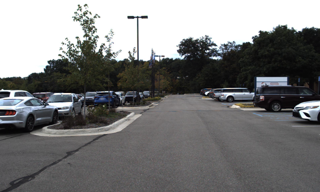

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(0.0, 0.0,…

In [21]:
# 1. Reconstruct 3D points from frame 1 using depth + intrinsics + poses
T_lidar_from_camera01 = np.matmul(np.linalg.inv(T_world_from_lidar), T_world_from_camera01)
pts3d_in_lidar_from_camera01 = reconstruct_depth_map(depth_camera01, K_camera01, T_lidar_from_camera01)

# 1-1. Visualize for debugging (should be a part of 1-2)
xyz3d_01 = pts3d_in_lidar_from_camera01.astype(np.float32)
valid = depth_camera01 > 0

rgb3d_01 = image_camera01[valid].astype(np.float32) / 255.0
xyz3d_01 = xyz3d_01[:, valid].T

# Image
display(Image.fromarray(image_camera01).resize(size=(image_camera01.shape[1]//2, image_camera01.shape[0]//2)))

# Reconstructed 3D from depth map (in world coordinate system, which is the same with LiDAR coordinate system in this example)
display(visualize_3d(xyz3d_01, rgb3d_01, size=0.2))


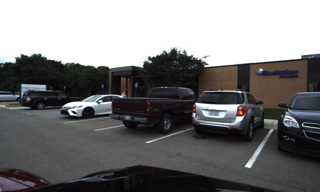

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(0.0, 0.0,…

In [22]:
# 1. Reconstruct 3D points from frame 1 using depth + intrinsics + poses
T_lidar_from_camera06 = np.matmul(np.linalg.inv(T_world_from_lidar), T_world_from_camera06)
pts3d_in_lidar_from_camera06 = reconstruct_depth_map(depth_camera06, K_camera06, T_lidar_from_camera06)

# 1-1. Visualize for debugging (should be a subset of full LiDAR point cloud shown in 1-2 below)
xyz3d_06 = pts3d_in_lidar_from_camera06.astype(np.float32)

valid = depth_camera06 > 0

rgb3d_06 = image_camera06[valid].astype(np.float32) / 255.0
xyz3d_06 = xyz3d_06[:, valid].T

# Image
display(Image.fromarray(image_camera06).resize(size=(image_camera06.shape[1]//2, image_camera06.shape[0]//2)))

# Reconstructed 3D from depth map (in world coordinate system, which is the same with LiDAR coordinate system in this dataset)
visualize_3d(xyz3d_06, rgb3d_06, size=0.2)

In [23]:
rgb3d_01_highlighted = copy.deepcopy(rgb3d_01)
rgb3d_06_highlighted = copy.deepcopy(rgb3d_06)

rgb3d_01_highlighted[:, 0] = np.clip(rgb3d_01_highlighted[:, 0] + 0.2, 0.0, 1.0)    # make it red-ish
rgb3d_06_highlighted[:, 1] = np.clip(rgb3d_06_highlighted[:, 1] + 0.2, 0.0, 1.0)    # make it green-ish

visualize_3d(np.vstack([xyz3d_01, xyz3d_06]), np.vstack([rgb3d_01_highlighted, rgb3d_06_highlighted]), size=0.2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(0.0, 0.0,…

In [24]:
# 1-2. Visualize LiDAR point cloud
# visualize_3d(pcd_lidar[:, :3], show_distance=[10, 20, 30, 40], size=0.1)

# (Optional) Visualize all (it could be helpful in debugging geometric transformations above)
xyz_all = np.vstack([pcd_lidar[:, :3], xyz3d_01, xyz3d_06]).astype(np.float32)
rgb_all = np.vstack([0.5 * np.ones_like(pcd_lidar[:, :3]), rgb3d_01_highlighted, rgb3d_06_highlighted]).astype(np.float32)
visualize_3d(xyz_all, rgb_all, show_distance=[10, 20, 30, 40], size=0.1)

C:\Users\leeju\anaconda3\Lib\site-packages\pythreejs\traits.py:257: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(0.0, 0.0,…

In [25]:
# Note that this function takes "T_cw" not "T_wc"

def project_points_3d(pts3d_world, K, T_cw=np.eye(4)):
    """Project 3D points back to image plane (i.e. depth map)    

    Parameters
    ----------
    pts3d_world : np.ndarray (3 x H x W)
        input 3D points in world coordinate
    K : np.ndarray (3 x 3)
        intrinsic matrix of the camera
    T_cw : np.ndarray (4 x 4)
        transformation to camera coordinate from world coordinate, i.e., X_cam = T_cw @ X_world

    Returns
    -------
    coords : np.ndarray (2 x H x W)
        projected 2D coordinates
    depth : np.ndarray (H x W)
        projected depth
    """
    
    h, w = pts3d_world.shape[1:]

    pts3d_world_homogeneous = np.concatenate([pts3d_world, np.ones((1, h, w))], axis=0)
    pts3d_cam = np.matmul(T_cw, pts3d_world_homogeneous.reshape(4, -1))   # (4 x N)    
    pts2d_img = np.matmul(K, pts3d_cam[:3])    # (3 x N)
    
    depth_on_camera = pts3d_cam[2].reshape(h, w)
    xx, yy, zz = pts2d_img.reshape(3, h, w)
    xx = (xx / zz + 1e-7).astype(np.int16)     
    yy = (yy / zz + 1e-7).astype(np.int16)         

    # The projected points are only valid if 
    #   1. the projected image coordinates are actually inside the image
    #   2. the depth of the 3D points in camera coordinate has positive value.
    #      (we cannot see the 3D points behind the image plane.)
    valid = np.logical_and.reduce([
        xx >= 0, xx < w,    # assume image sizes are always the same
        yy >= 0, yy < h,    # assume image sizes are always the same
        depth_on_camera > 0.0,
    ])
    
    coords = np.stack([xx, yy], axis=0)
    return coords, depth_on_camera, valid

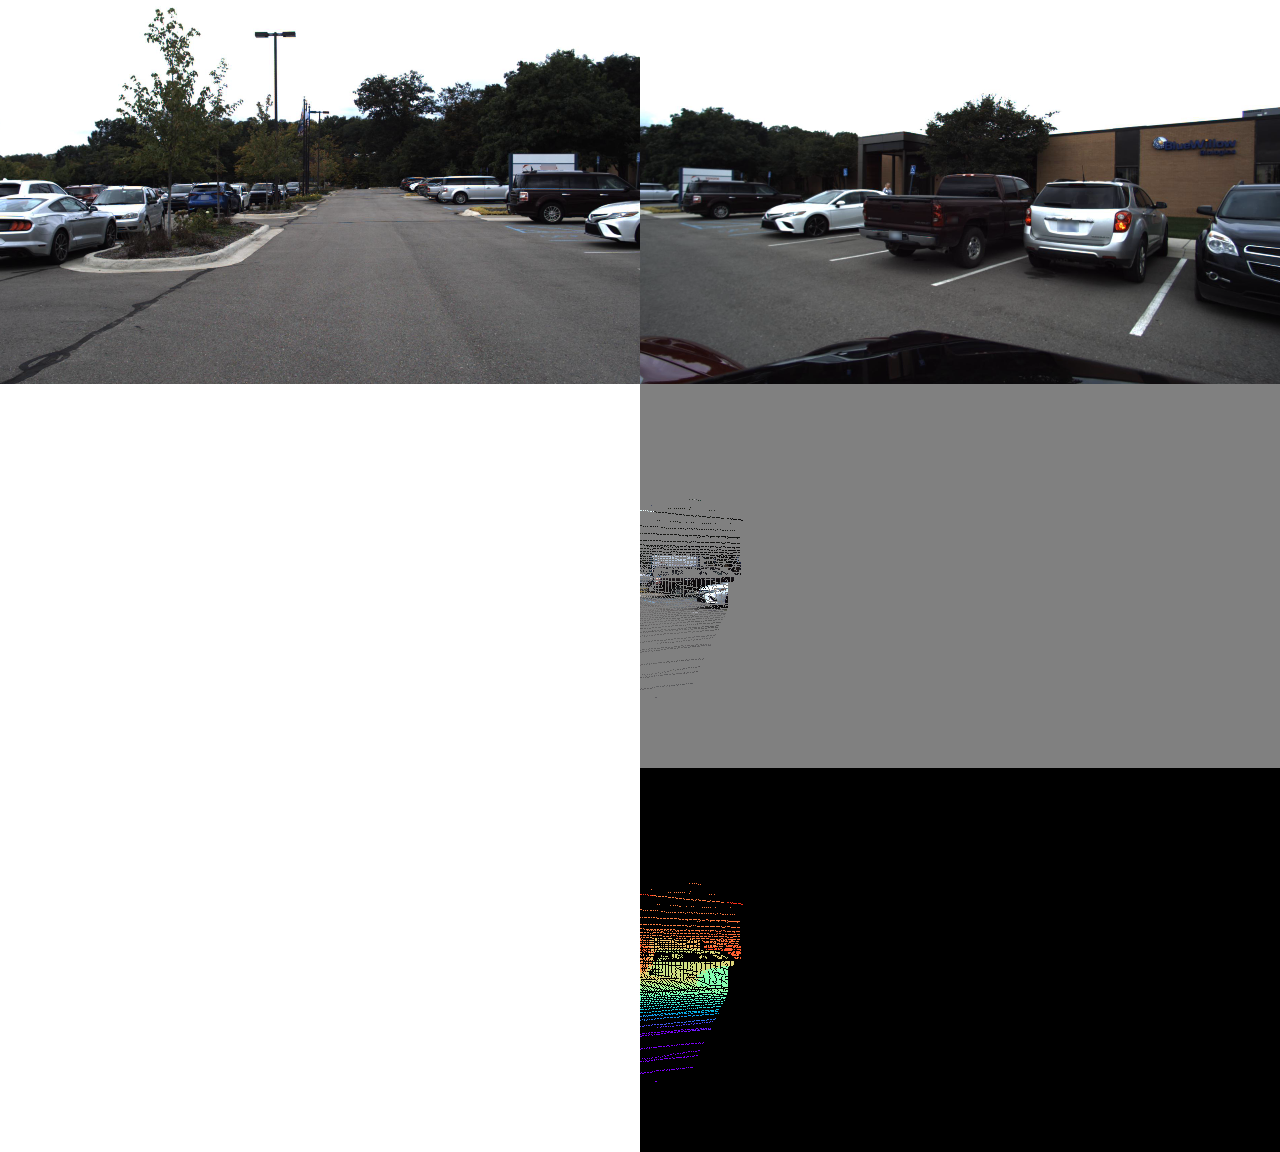

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(0.0, 0.0,…

In [26]:
T_camera06_from_lidar = np.linalg.inv(T_lidar_from_camera06)
coords, depth_value_on_camera06, seen_on_camera06 = project_points_3d(pts3d_in_lidar_from_camera01, K_camera06, T_camera06_from_lidar)

### Synthesize image/depth
xx, yy = coords
warped_depth_on_camera06_from_camera01 = np.zeros_like(depth_value_on_camera06)
warped_depth_on_camera06_from_camera01[yy[seen_on_camera06], xx[seen_on_camera06]] = depth_value_on_camera06[seen_on_camera06]

warped_image_on_camera06_from_camera01 = 128 * np.ones_like(image_camera01)
warped_image_on_camera06_from_camera01[yy[seen_on_camera06], xx[seen_on_camera06]] = image_camera01[seen_on_camera06]

# Image
stacked_image = np.vstack([
    np.hstack([image_camera01, image_camera06]),
    np.hstack([255 * np.ones_like(image_camera01), warped_image_on_camera06_from_camera01]),
    np.hstack([255 * np.ones_like(image_camera01), viz_depth(np.clip(warped_depth_on_camera06_from_camera01, 0.0, None), background=0.0)]),
])

display(Image.fromarray(stacked_image))

# 1-1. Visualize for debugging
valid = depth_camera01 > 0
xyz3d = pts3d_in_lidar_from_camera01.astype(np.float32)

image_overlapped = copy.deepcopy(image_camera01)
image_overlapped[seen_on_camera06] = (255, 0, 0)

rgb3d = image_overlapped[valid].astype(np.float32) / 255.0
xyz3d = xyz3d[:, valid].T

# Reconstructed 3D from depth map (in world coordinate system, which is the same with LiDAR coordinate system in this dataset)
display(visualize_3d(xyz3d, rgb3d, size=0.2))